# Sign Language Gesture Images Dataset Description

- dataset: https://www.kaggle.com/datasets/ahmedkhanak1995/sign-language-gesture-images-dataset/data

In [89]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import hashlib
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
import mediapipe as mp
import cv2 as cv
import copy
import itertools
from sklearn.manifold import TSNE
RANDOM_SEED = 42

In [90]:
# Dataset Path
data_dir = '../data'
CSV_OUTPUT_PATH = '../model/keypoint_classifier/keypoint2.csv'

LABELS = sorted(os.listdir(data_dir))
NUM_CLASSES = len(LABELS)
NUM_CLASSES

37

### Function to load dataset structure

In [91]:
def load_dataset_structure(data_dir):
    class_names = os.listdir(data_dir)
    class_distribution = {}
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)
        class_distribution[class_name] = len(images)

    return class_names, class_distribution

In [92]:
# Load dataset structure
class_names, class_distribution = load_dataset_structure(data_dir)
print("Classes:", class_names)

Classes: ['O', 'W', '7', '2', 'Z', 'U', 'N', 'H', 'C', 'Y', '0', 'P', 'R', 'B', 'D', '5', 'F', '_', '6', '1', 'L', 'I', 'E', 'T', 'K', 'S', 'A', 'M', 'X', '4', 'G', '3', 'Q', '8', 'V', 'J', '9']


In [93]:
class_distribution

{'O': 815,
 'W': 1481,
 '7': 2276,
 '2': 2273,
 'Z': 1445,
 'U': 1480,
 'N': 1482,
 'H': 1480,
 'C': 1479,
 'Y': 815,
 '0': 2276,
 'P': 1481,
 'R': 1482,
 'B': 1477,
 'D': 1478,
 '5': 2276,
 'F': 1484,
 '_': 1437,
 '6': 2266,
 '1': 2277,
 'L': 1480,
 'I': 1482,
 'E': 816,
 'T': 1479,
 'K': 1475,
 'S': 815,
 'A': 1478,
 'M': 817,
 'X': 1482,
 '4': 2268,
 'G': 1482,
 '3': 2246,
 'Q': 1482,
 '8': 2275,
 'V': 1486,
 'J': 1443,
 '9': 2275}

### Function to check for corrupted images

In [94]:
def check_image_integrity(data_dir, class_names):
    corrupted_files = []
    for class_name in tqdm(class_names):
        class_path = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, image_name)
                img = Image.open(img_path)
                img.verify()
            except Exception:
                corrupted_files.append(img_path)
    return corrupted_files

In [95]:
# Check image integrity
corrupted_files = check_image_integrity(data_dir, class_names)
print("Corrupted Files:", corrupted_files)

100%|██████████| 37/37 [00:01<00:00, 29.79it/s]

Corrupted Files: []


### Function to visualize class distribution

In [96]:
def plot_class_distribution(class_distribution):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
    plt.xticks(rotation=90)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

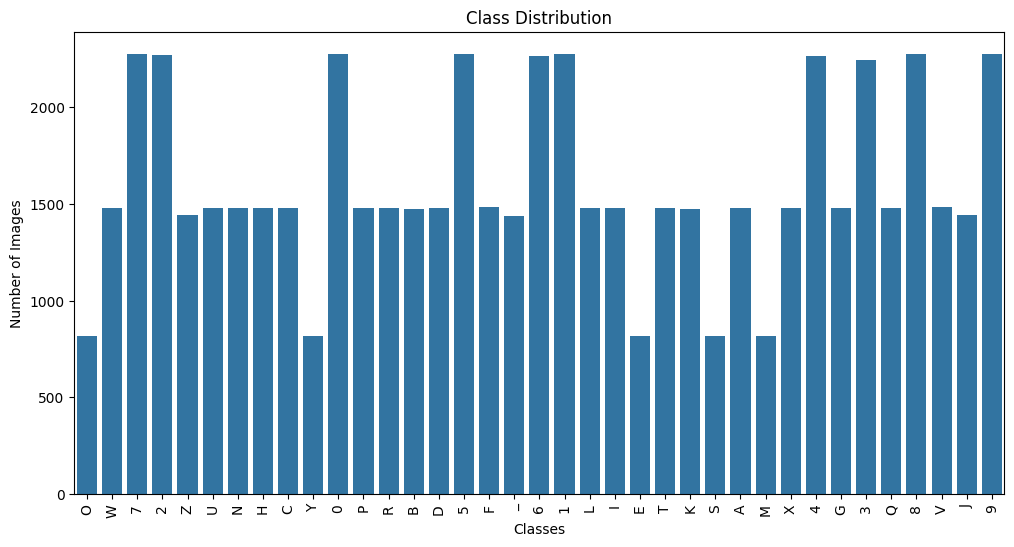

In [97]:
# Plot class distribution
plot_class_distribution(class_distribution)

### Function to analyze image properties

In [98]:
def analyze_image_properties(data_dir, class_names):
    image_shapes = []
    aspect_ratios = []
    file_sizes = []

    for class_name in tqdm(class_names):
        class_path = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_path):
            img_path = os.path.join(class_path, image_name)
            img = Image.open(img_path)
            image_shapes.append(img.size)
            aspect_ratios.append(img.size[0] / img.size[1])
            file_sizes.append(os.path.getsize(img_path))

    return image_shapes, aspect_ratios, file_sizes

### Function to visualize image properties

In [99]:
def visualize_image_properties(image_shapes, aspect_ratios, file_sizes):
    # Image Dimensions Distribution
    widths, heights = zip(*image_shapes)
    plt.figure(figsize=(12, 6))
    sns.histplot(widths, bins=30, kde=True, label='Width')
    sns.histplot(heights, bins=30, kde=True, label='Height')
    plt.legend()
    plt.title('Image Dimensions Distribution')
    plt.xlabel('Dimension')
    plt.ylabel('Frequency')
    plt.show()

    # Aspect Ratio Distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(aspect_ratios, bins=30, kde=True)
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Frequency')
    plt.show()

    # File Size Distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(file_sizes, bins=30, kde=True)
    plt.title('File Size Distribution')
    plt.xlabel('File Size (bytes)')
    plt.ylabel('Frequency')
    plt.show()

In [100]:
# Analyze image properties
image_shapes, aspect_ratios, file_sizes = analyze_image_properties(data_dir, class_names)

# image shapes: (50, 50)
# aspect ratios: 1.0

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:01<00:00, 28.50it/s]


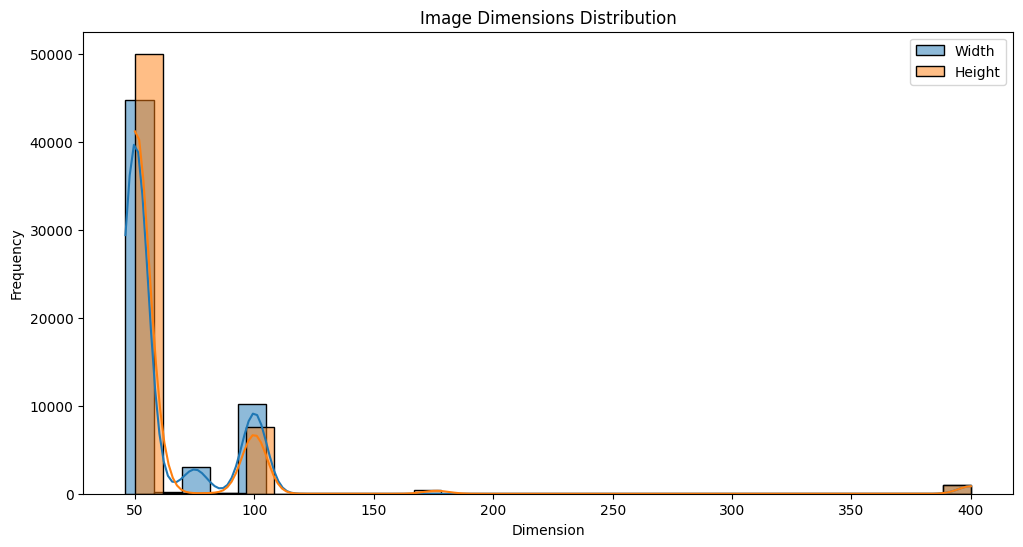

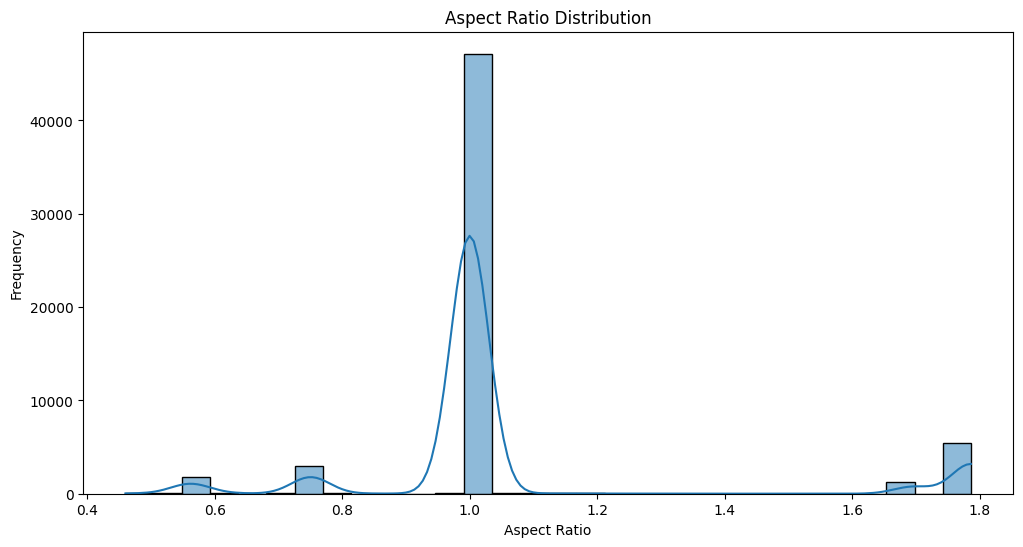

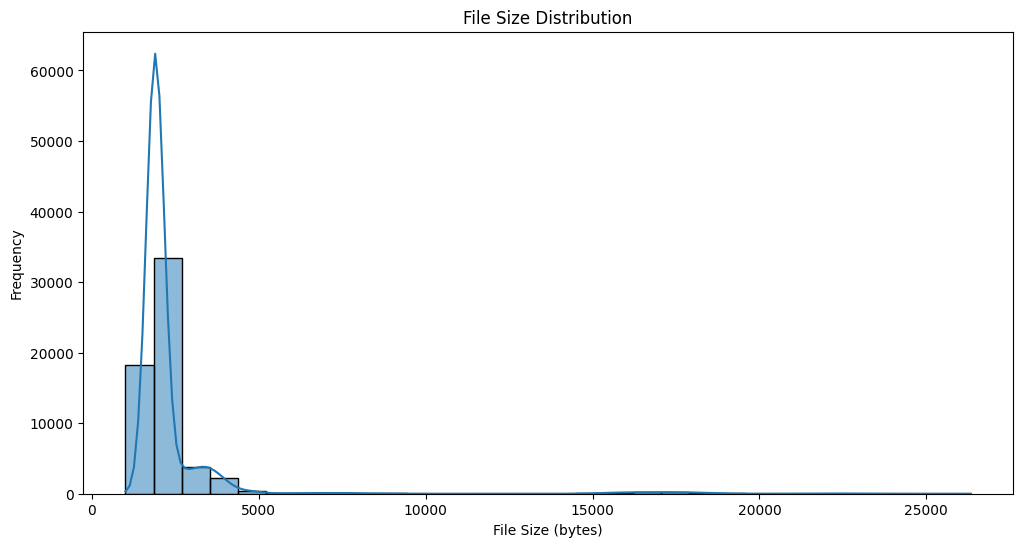

In [101]:
visualize_image_properties(image_shapes, aspect_ratios, file_sizes)

### Function to detect duplicate images

In [102]:
def detect_duplicates(data_dir, class_names):
    hash_groups = {}

    for class_name in tqdm(class_names, desc="Scanning classes"):
        class_path = os.path.join(data_dir, class_name)
            
        for image_name in tqdm(os.listdir(class_path), desc=f"Scanning {class_name}", leave=False):
            img_path = os.path.join(class_path, image_name)
            if not os.path.isfile(img_path):
                continue
                
            try:
                with open(img_path, 'rb') as f:
                    file_hash = hashlib.sha256(f.read()).hexdigest()
                    
                # Add file to the list for this hash
                if file_hash not in hash_groups:
                    hash_groups[file_hash] = []
                hash_groups[file_hash].append(img_path)
                    
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Return only groups that have duplicates (more than 1 file)
    duplicate_groups = {hash_val: paths for hash_val, paths in hash_groups.items() if len(paths) > 1}
    return duplicate_groups

In [103]:
# Detect duplicate images
duplicate_groups = detect_duplicates(data_dir, class_names)
print("Duplicate Images:", len(duplicate_groups))
duplicate_groups

Scanning classes:   0%|          | 0/37 [00:00<?, ?it/s]

Scanning classes: 100%|██████████| 37/37 [00:00<00:00, 47.31it/s]

Duplicate Images: 0


{}

In [104]:
def remove_duplicates(data_dir, class_names, dry_run=True):
    """
    Remove duplicate images from the dataset.
    
    Args:
        data_dir (str): Path to the dataset directory
        class_names (list): List of class/folder names to check
        dry_run (bool): If True, only show what would be removed without actually deleting
    
    Returns:
        dict: Statistics about the removal process
    """
    
    print("Detecting duplicates...")
    duplicate_groups = detect_duplicates(data_dir, class_names)
    
    if not duplicate_groups:
        print("No duplicates found!")
        return {
            'total_duplicates': 0,
            'removed_count': 0,
            'saved_space': 0,
            'errors': 0
        }
    print(duplicate_groups)
    # Count total files to be removed
    total_files_to_remove = sum(len(files) - 1 for files in duplicate_groups.values())
    total_duplicate_groups = len(duplicate_groups)
    
    print(f"Found {total_duplicate_groups} groups of duplicates")
    print(f"Total files to be removed: {total_files_to_remove}")
    
    # Statistics
    stats = {
        'total_duplicates': total_files_to_remove,
        'removed_count': 0,
        'saved_space': 0,
        'errors': 0
    }
    
    print(f"\nRemoval plan:")
    print(f"{'Keep (Original)':<50} {'Remove (Duplicates)'}")
    print("-" * 80)
    
    for hash_val, file_list in duplicate_groups.items():
        original = file_list[0]  # Keep the first file
        duplicates_to_remove = file_list[1:]  # Remove all others
        
        print(f"{original:<50} {len(duplicates_to_remove)} duplicate(s)")
        for dup in duplicates_to_remove:
            print(f"{'':>50} -> {dup}")
        print()  # Empty line for readability
    
    if dry_run:
        print(f"\n[DRY RUN] Would remove {total_files_to_remove} duplicate files from {total_duplicate_groups} groups")
        return stats
    
    # Remove duplicates
    print("\nRemoving duplicates...")
    files_to_remove = []
    for file_list in duplicate_groups.values():
        original = file_list[0]  # Keep first file
        files_to_remove.extend(file_list[1:])  # Remove all others
    
    print(files_to_remove)
    for duplicate in tqdm(files_to_remove, desc="Removing files"):
        try:
            # Get file size before deletion for space calculation
            file_size = os.path.getsize(duplicate)
            
            # Remove the duplicate file
            os.remove(duplicate)
            
            stats['removed_count'] += 1
            stats['saved_space'] += file_size
            
            message = f"Removed duplicate: {duplicate}"
            print(f"✓ {message}")
            
                
        except Exception as e:
            stats['errors'] += 1
            error_message = f"Error removing {duplicate}: {e}"
            print(f"✗ {error_message}")
            
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"REMOVAL SUMMARY")
    print(f"{'='*60}")
    print(f"Total duplicates found: {stats['total_duplicates']}")
    print(f"Successfully removed: {stats['removed_count']}")
    print(f"Errors: {stats['errors']}")
    print(f"Space saved: {stats['saved_space'] / (1024*1024):.2f} MB")

    
    return stats

In [105]:
remove_duplicates(data_dir, class_names, dry_run=False)

Detecting duplicates...


Scanning classes: 100%|██████████| 37/37 [00:00<00:00, 52.66it/s]

No duplicates found!


{'total_duplicates': 0, 'removed_count': 0, 'saved_space': 0, 'errors': 0}

### Function to visualize random samples

In [106]:
def visualize_random_samples(data_dir, class_names):
    plt.figure(figsize=(12, 12))
    for i, class_name in enumerate(class_names[:9]):
        class_path = os.path.join(data_dir, class_name)
        random_image = np.random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, random_image)
        img = Image.open(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

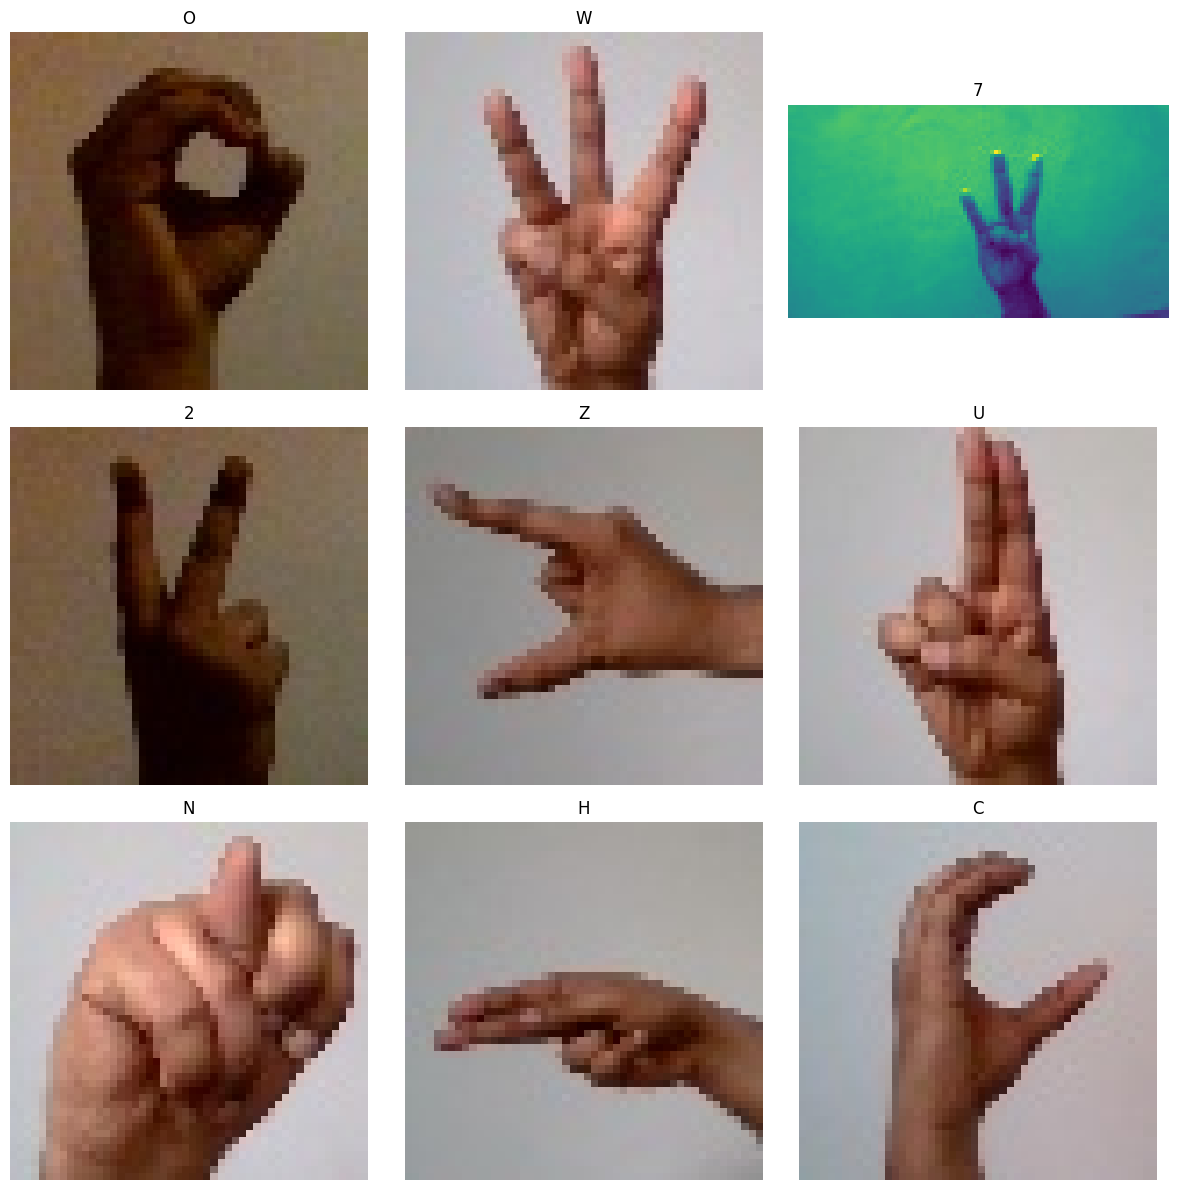

In [107]:
# Visualize random samples
visualize_random_samples(data_dir, class_names)

100%|██████████| 37/37 [00:08<00:00,  4.43it/s]


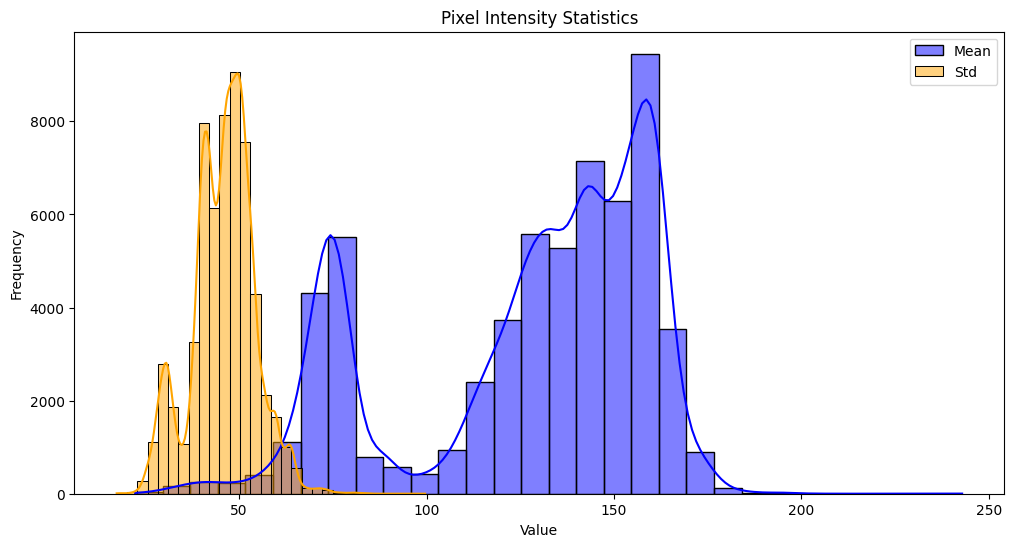

In [108]:
# Statistical Analysis
image_means = []
image_stds = []

for class_name in tqdm(class_names):
    class_path = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_path):
        img_path = os.path.join(class_path, image_name)
        img = np.array(Image.open(img_path))
        image_means.append(np.mean(img))
        image_stds.append(np.std(img))

plt.figure(figsize=(12, 6))
sns.histplot(image_means, bins=30, kde=True, color='blue', label='Mean')
sns.histplot(image_stds, bins=30, kde=True, color='orange', label='Std')
plt.legend()
plt.title('Pixel Intensity Statistics')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [109]:
# Summary
print("Dataset Summary:")
print(f"Number of Classes: {len(class_names)}")
print(f"Total Images: {sum(class_distribution.values())}")
print(f"Corrupted Files: {len(corrupted_files)}")

Dataset Summary:
Number of Classes: 37
Total Images: 59241
Corrupted Files: 0


# Preprocess the images

In [110]:
def calc_landmark_list(image, landmarks):
    """
    Calculate the landmark list
    """
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point


def pre_process_landmark(landmark_list):
    """
    Convert the landmark list to a one-dimensional list
    -After this subtraction, the wrist becomes (0, 0).
    -All other landmark positions are now measured relative to the wrist.
    -If the hand is centered over the wrist, fingers will be distributed roughly evenly to the left and right.
    -So on average, the hand shape will be horizontally centered, and the mean x-values of many landmarks will be near 0.

    Input:
    landmark_list: list of 21 landmark points, each point is a tuple of (x, y)
    Output:
    temp_landmark_list: list of 42 features, each feature is a float
    """
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates, base point is at the wrist
    # => Removes dependence on the hand’s position in the image.
    # => Now all gestures are centered at (0, 0), no matter where the hand was on screen.
    base_x, base_y = 0, 0 
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list)) 

    # Normalization, 
    # max_value is the maximum absolute value in the list
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        # Ensures different hand sizes (big/small hands, distance from camera) don’t affect classification.
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

In [111]:
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated

def process_image(image, hands):
    preprocessed_results = []
    
    def try_process(img):
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0]
            landmarks_list = calc_landmark_list(img, landmarks)
            return pre_process_landmark(landmarks_list)
        return None
    
    # Original + flipped + rotated (-10, +10)
    for img_variant in [
        image,
        cv.flip(image, 1),
        rotate_image(image, -10),
        rotate_image(image, 10),
        rotate_image(cv.flip(image, 1), -10),
        rotate_image(cv.flip(image, 1), 10)
    ]:
        result = try_process(img_variant)
        if result:
            preprocessed_results.append(result)
            
    return preprocessed_results if preprocessed_results else None

In [113]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.2
)

#Open CSV to write 
with open(CSV_OUTPUT_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    
    for label in tqdm(LABELS):
        print("label: ", label,"type: ", type(label))
        folder_path = os.path.join(data_dir, label)
        
        if not os.path.exists(folder_path):
            continue    
        for file_name in tqdm(os.listdir(folder_path)):
            if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            
            image_path = os.path.join(folder_path, file_name)
            image = cv.imread(image_path)
            if image is None:
                continue
            
            
            preprocessed = process_image(image, hands)
            if preprocessed is None:
                continue
            
            for preprocessed_image in preprocessed:
                writer.writerow([label] + preprocessed_image)
            
hands.close()
print("Done writing keypoint2.csv")

I0000 00:00:1750291656.756048   45388 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750291656.762638  158619 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (ADL GT2)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1750291656.775026  158600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


label:  0 type:  <class 'str'>


W0000 00:00:1750291656.788910  158607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/thong/Desktop/hand-gesture-detection/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
  3%|▎         | 1/37 [04:39<2:47:57, 279.93s/it]

label:  1 type:  <class 'str'>


  5%|▌         | 2/37 [10:05<2:59:06, 307.05s/it]

label:  2 type:  <class 'str'>


  8%|▊         | 3/37 [15:13<2:54:13, 307.45s/it]

label:  3 type:  <class 'str'>


 11%|█         | 4/37 [20:24<2:49:45, 308.66s/it]

label:  4 type:  <class 'str'>


 14%|█▎        | 5/37 [25:38<2:45:42, 310.72s/it]

label:  5 type:  <class 'str'>


 16%|█▌        | 6/37 [31:41<2:49:43, 328.49s/it]

label:  6 type:  <class 'str'>


 19%|█▉        | 7/37 [36:29<2:37:37, 315.24s/it]

label:  7 type:  <class 'str'>


 22%|██▏       | 8/37 [41:36<2:31:07, 312.68s/it]

label:  8 type:  <class 'str'>


 24%|██▍       | 9/37 [46:55<2:26:48, 314.61s/it]

label:  9 type:  <class 'str'>


 27%|██▋       | 10/37 [52:29<2:24:16, 320.62s/it]

label:  A type:  <class 'str'>


 30%|██▉       | 11/37 [56:25<2:07:37, 294.51s/it]

label:  B type:  <class 'str'>


 32%|███▏      | 12/37 [1:00:52<1:59:15, 286.22s/it]

label:  C type:  <class 'str'>


 35%|███▌      | 13/37 [1:05:15<1:51:43, 279.30s/it]

label:  D type:  <class 'str'>


 38%|███▊      | 14/37 [1:09:42<1:45:37, 275.56s/it]

label:  E type:  <class 'str'>


 41%|████      | 15/37 [1:11:20<1:21:26, 222.12s/it]

label:  F type:  <class 'str'>


 43%|████▎     | 16/37 [1:15:55<1:23:13, 237.78s/it]

label:  G type:  <class 'str'>


 46%|████▌     | 17/37 [1:20:35<1:23:33, 250.67s/it]

label:  H type:  <class 'str'>


 49%|████▊     | 18/37 [1:25:18<1:22:25, 260.30s/it]

label:  I type:  <class 'str'>


 51%|█████▏    | 19/37 [1:29:59<1:19:55, 266.40s/it]

label:  J type:  <class 'str'>


 54%|█████▍    | 20/37 [1:34:28<1:15:42, 267.23s/it]

label:  K type:  <class 'str'>


 57%|█████▋    | 21/37 [1:39:10<1:12:25, 271.61s/it]

label:  L type:  <class 'str'>


 59%|█████▉    | 22/37 [1:43:54<1:08:53, 275.57s/it]

label:  M type:  <class 'str'>


 62%|██████▏   | 23/37 [1:45:33<51:54, 222.45s/it]  

label:  N type:  <class 'str'>


 65%|██████▍   | 24/37 [1:49:57<50:52, 234.80s/it]

label:  O type:  <class 'str'>


 68%|██████▊   | 25/37 [1:51:42<39:12, 196.03s/it]

label:  P type:  <class 'str'>


 70%|███████   | 26/37 [1:56:26<40:45, 222.32s/it]

label:  Q type:  <class 'str'>


 73%|███████▎  | 27/37 [2:01:08<40:03, 240.35s/it]

label:  R type:  <class 'str'>


 76%|███████▌  | 28/37 [2:05:53<38:02, 253.65s/it]

label:  S type:  <class 'str'>


 78%|███████▊  | 29/37 [2:07:57<28:39, 214.91s/it]

label:  T type:  <class 'str'>


 81%|████████  | 30/37 [2:11:34<25:06, 215.27s/it]

label:  U type:  <class 'str'>


 84%|████████▍ | 31/37 [2:16:17<23:35, 235.86s/it]

label:  V type:  <class 'str'>


 86%|████████▋ | 32/37 [2:21:02<20:52, 250.57s/it]

label:  W type:  <class 'str'>


 89%|████████▉ | 33/37 [2:27:18<19:12, 288.19s/it]

label:  X type:  <class 'str'>


 92%|█████████▏| 34/37 [2:32:38<14:52, 297.51s/it]

label:  Y type:  <class 'str'>


 95%|█████████▍| 35/37 [2:34:28<08:02, 241.33s/it]

label:  Z type:  <class 'str'>


 97%|█████████▋| 36/37 [2:38:58<04:10, 250.07s/it]

label:  _ type:  <class 'str'>


100%|██████████| 37/37 [2:43:05<00:00, 264.47s/it]


Done writing keypoint2.csv
